<a href="https://colab.research.google.com/github/skywalker0803r/works/blob/master/C9IP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import warnings 
warnings.simplefilter('ignore')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# LOAD

In [0]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

train = pd.read_csv('/content/drive/My Drive/台塑輕油案子/data/train_4521.csv',index_col=0).reset_index(drop=True)
test_250 = pd.read_csv('/content/drive/My Drive/台塑輕油案子/data/test_250.csv',index_col=0).reset_index(drop=True)
test_170 = pd.read_csv('/content/drive/My Drive/台塑輕油案子/data/test_170.csv',index_col=0).reset_index(drop=True)

# 整理資料

In [3]:
test_200 = test_250.loc[ test_250.index % 5 != 0 ,:]#5不可整除
test_50 = test_250.loc[ test_250.index % 5 == 0 ,:]#5可以整除
train = train.append(test_200)#200筆加入train
print(train.shape)
print(test_170.shape)
print(test_50.shape)

(4721, 27)
(170, 27)
(50, 27)


# def features y_name

In [0]:
features = ['T10','T50','T90','N+A']
y_name = 'C9IP'

# features scaler

In [0]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(train[features])

train[features] = scaler.transform(train[features])
test_170[features] = scaler.transform(test_170[features])
test_50[features] = scaler.transform(test_50[features])

# CORR WITH X

找找高相關特徵

In [6]:
corr_x = abs(train.iloc[:,:4].join(train[y_name]).corr()).loc[[y_name]].T.sort_values(by=y_name,ascending=False).T
corr_x

,C9IP,T50,T10,N+A,T90
C9IP,1.0,0.65164,0.634649,0.533834,0.25437


# CORR WITH Y

找找高相關y

In [7]:
corr_y = abs(train.iloc[:,4:].corr())[[y_name]].sort_values(by=y_name,ascending=False).T
corr_y

,C9IP,C8NP,C9NP,C8IP,C6N,C7NP,C6IP,C5NP,C5IP,C10IP,C9A,C5N,C7N,C7IP,C8N,C6A,C6NP,C7A,C8A,C9N,C10A,C10N,C10NP
C9IP,1.0,0.888828,0.881956,0.823955,0.806291,0.797645,0.765319,0.740485,0.730607,0.66422,0.631929,0.592493,0.592481,0.422237,0.392798,0.369814,0.363449,0.316158,0.276271,0.217092,0.184332,0.058966,0.032782


# 特徵萃取

In [0]:
from sklearn.manifold import isomap
iso_col = ['T50','N+A']
iso = isomap.Isomap(n_components=1).fit(train[iso_col])
#轉換
train['iso_x'] = iso.transform(train[iso_col])
test_170['iso_x'] = iso.transform(test_170[iso_col])
test_50['iso_x'] = iso.transform(test_50[iso_col])

# 目標萃取

In [0]:
from sklearn.decomposition import pca
pca_col = ['C9IP','C8NP']
pca = pca.PCA(n_components=1).fit(train[pca_col])
#轉換
train['pca_y'] = pca.transform(train[pca_col])
test_170['pca_y'] = pca.transform(test_170[pca_col])
test_50['pca_y'] = pca.transform(test_50[pca_col])

# 檢查相關性

這裡希望看到是漂亮的線性相關

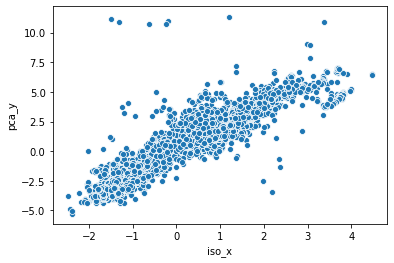

,iso_x,pca_y,C9IP
iso_x,1.000000,0.924616,-0.897387
pca_y,0.924616,1.000000,-0.972681
C9IP,-0.897387,-0.972681,1.000000


In [10]:
sns.scatterplot(x='iso_x',y='pca_y',data=train)
plt.show()
train.corr().loc[['iso_x','pca_y',y_name],['iso_x','pca_y',y_name]]

# modeling

評分指標

In [0]:
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
from math import sqrt
def metric(y_t,y_p):
  res = {'R2':r2_score(y_t,y_p),
         'RMSE':sqrt(mean_squared_error(y_t,y_p)),
         'mean_absolute_error':mean_absolute_error(y_t,y_p)}
  return pd.DataFrame(res,index=['score'])

In [12]:
import xgboost
from sklearn.svm import SVR
from math import sqrt
from lightgbm import LGBMRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
import warnings 
warnings.simplefilter('ignore')

#選擇模型
#model = DecisionTreeRegressor(max_depth=1)
#model = xgboost.XGBRegressor(objective='reg:squarederror')
#model = SVR()
model = LinearRegression()

#交叉驗證
val_scores = cross_validate(model,train[['iso_x']],train['pca_y'],cv=5)

#交叉驗證結果
print('交叉驗證分數:',val_scores['test_score'])
print('交叉驗證平均分數:',val_scores['test_score'].mean())

交叉驗證分數: [0.84764456 0.79964844 0.84397666 0.87208529 0.84770215]
交叉驗證平均分數: 0.8422114185474443


# fit & predict

In [0]:
# fit 
model.fit(train[['iso_x']],train['pca_y'])
# predict
train['y_pred'] = model.predict(train[['iso_x']])
test_170['y_pred'] = model.predict(test_170[['iso_x']])
test_50['y_pred'] = model.predict(test_50[['iso_x']])

# plot

data for plot

In [0]:
by_col = 'iso_x'
train_sample_point = train.sample(1000).sort_values(by = by_col)
test_170_point = test_170.sort_values(by = by_col)
test_50_point = test_50.sort_values(by = by_col)

plot function

In [0]:
def pred_plot(df,by_col):
  fig = plt.figure(figsize=(20,5))
  plt.plot(df[by_col],df['y_pred'],label='pred line',color='red')
  plt.scatter(df[by_col],df['pca_y'],label='data point')
  plt.xlabel(by_col)
  plt.ylabel('pca_y')
  plt.legend()
  plt.show()

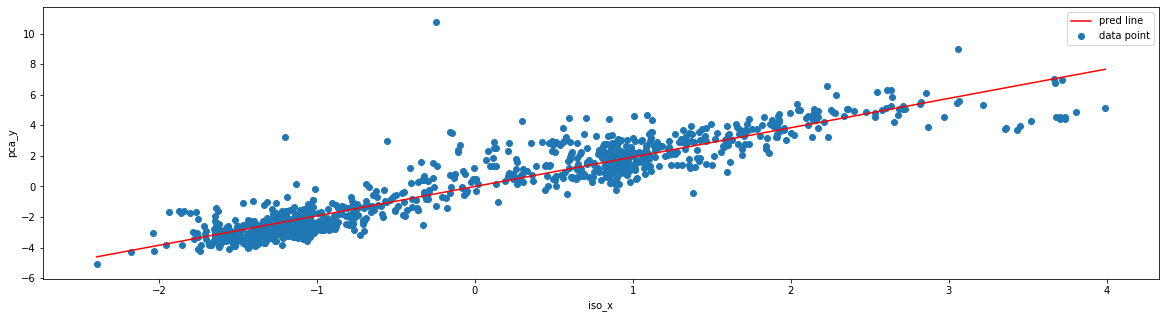

train_scores:


,R2,RMSE,mean_absolute_error
score,0.854914,1.053397,0.704607


In [16]:
pred_plot(train_sample_point,by_col)
plt.show()
print('train_scores:')
metric(train['pca_y'],train['y_pred'])

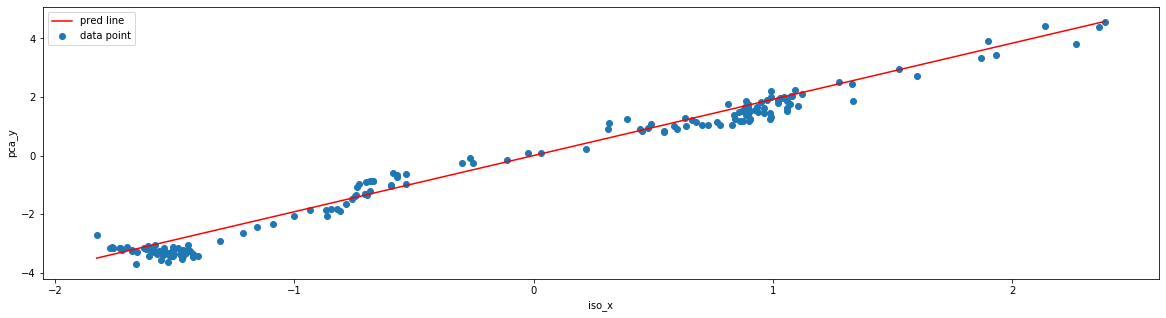

test_170_scores:


,R2,RMSE,mean_absolute_error
score,0.978935,0.33576,0.277069


In [17]:
pred_plot(test_170_point,by_col)
plt.show()
print('test_170_scores:')
metric(test_170['pca_y'],test_170['y_pred'])

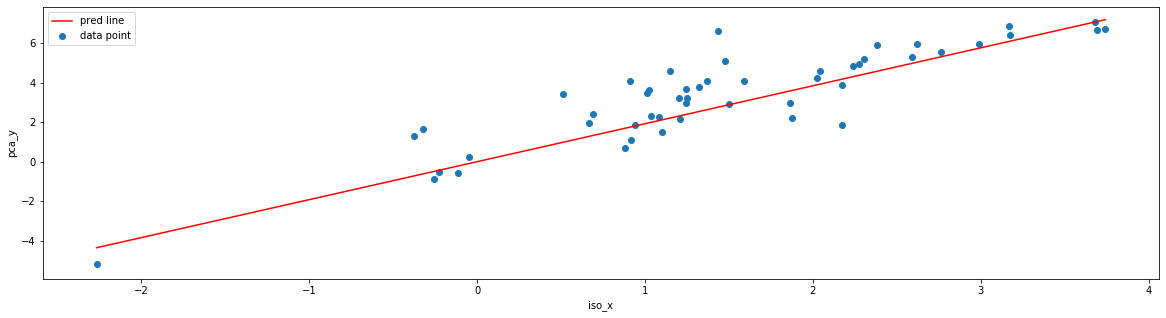

test_50_scores:


,R2,RMSE,mean_absolute_error
score,0.722514,1.246437,0.94592


In [18]:
pred_plot(test_50_point,by_col)
plt.show()
print('test_50_scores:')
metric(test_50['pca_y'],test_50['y_pred'])

# 預測表現(還原)

In [19]:
train_pred_all = pd.DataFrame(pca.inverse_transform(train[['pca_y']]),columns=pca_col)
res = pd.DataFrame()
for col in pca_col:
  res = res.append(metric(train[col],train_pred_all[col]))
res.index = pca_col
res.loc['AVG'] = res.mean()
res

,R2,RMSE,mean_absolute_error
C9IP,0.946108,0.470498,0.333412
C8NP,0.942696,0.478205,0.338874
AVG,0.944402,0.474352,0.336143


In [20]:
test_170_pred_all = pd.DataFrame(pca.inverse_transform(test_170[['pca_y']]),columns=pca_col)
res = pd.DataFrame()
for col in pca_col:
  res = res.append(metric(test_170[col],test_170_pred_all[col]))
res.index = pca_col
res.loc['AVG'] = res.mean()
res

,R2,RMSE,mean_absolute_error
C9IP,0.945685,0.368583,0.297664
C8NP,0.953015,0.374621,0.302541
AVG,0.949350,0.371602,0.300103


In [21]:
test_50_pred_all = pd.DataFrame(pca.inverse_transform(test_50[['pca_y']]),columns=pca_col)
res = pd.DataFrame()
for col in pca_col:
  res = res.append(metric(test_50[col],test_50_pred_all[col]))
res.index = pca_col
res.loc['AVG'] = res.mean()
res

,R2,RMSE,mean_absolute_error
C9IP,0.862157,0.771344,0.618361
C8NP,0.746233,0.783980,0.628491
AVG,0.804195,0.777662,0.623426


# check outliers

In [22]:
loss = (test_170_point['pca_y'] - test_170_point['y_pred'])**2 # 平方誤差
loss = loss.sort_values(ascending=False)
test_170_point['out'] = False
test_170_point.loc[loss.head(5).index,'out'] = True
print(loss.head(5))

121    0.599176
64     0.558791
62     0.534434
55     0.504271
20     0.495914
dtype: float64


In [23]:
loss = (test_50_point['pca_y'] - test_50_point['y_pred'])**2 # 平方誤差
loss = loss.sort_values(ascending=False)
test_50_point['out'] = False
test_50_point.loc[loss.head(5).index,'out'] = True
print(loss.head(5))

95     14.961900
135     5.999811
85      5.795046
175     5.311298
55      5.281844
dtype: float64


# plot out

In [0]:
def d_out_score(df):
  df = df.loc[df['out'] == False]
  return metric(df['pca_y'],df['y_pred'])

In [0]:
def d_out_all_score(df):
  df = df.loc[df['out'] == False]
  df_pred_all = pd.DataFrame(pca.inverse_transform(df[['pca_y']]),columns=pca_col)
  res = pd.DataFrame()
  for col in pca_col:
    res = res.append(metric(df[col],df_pred_all[col]))
  res.index = pca_col
  res.loc['AVG'] = res.mean()
  return res

In [0]:
def plot_out(df):
  fig = plt.figure(figsize=(20,5))
  out_point = df[df['out'] == True]
  plt.plot(df[by_col],df['y_pred'],label='pred line',color='red')
  plt.scatter(df[by_col],df['pca_y'],label='test point')
  plt.scatter(out_point[by_col],out_point['pca_y'],label='out point',color='orange')
  plt.xlabel(by_col)
  plt.ylabel('pca_y')
  plt.legend()
  plt.show()

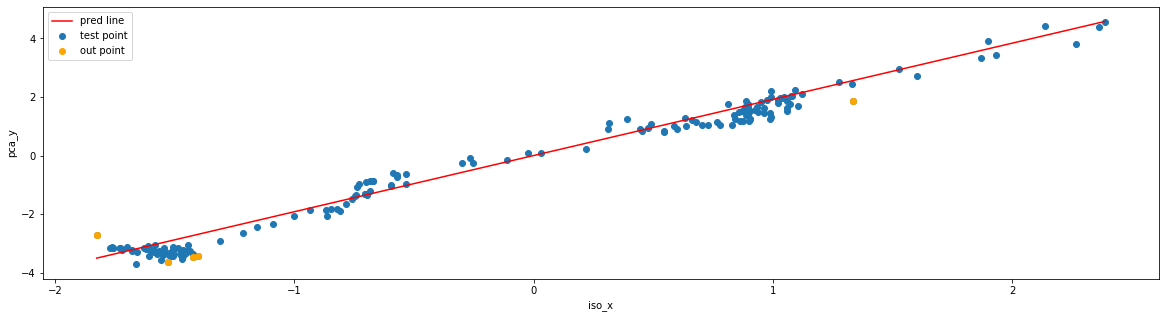

,R2,RMSE,mean_absolute_error
score,0.98112,0.315963,0.263241


In [27]:
plot_out(test_170_point)
plt.show()
d_out_score(test_170_point)

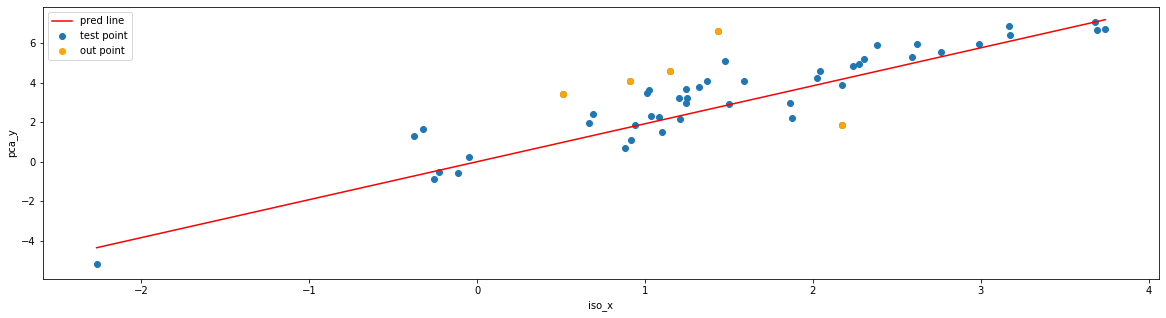

,R2,RMSE,mean_absolute_error
score,0.847641,0.946695,0.754852


In [28]:
plot_out(test_50_point)
plt.show()
d_out_score(test_50_point)

# drop out all score

In [29]:
d_out_all_score(test_170_point)

,R2,RMSE,mean_absolute_error
C9IP,0.944633,0.370686,0.300260
C8NP,0.951783,0.376759,0.305179
AVG,0.948208,0.373722,0.302720


In [30]:
d_out_all_score(test_50_point)

,R2,RMSE,mean_absolute_error
C9IP,0.867605,0.783406,0.630122
C8NP,0.739862,0.796239,0.640444
AVG,0.803733,0.789822,0.635283
